# Dataset

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder # Used for loading images structured in folders
import timm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

In [5]:
class RiceClassifier(Dataset): 
    # Custom Dataset class required by PyTorch for data loading
    def __init__ (self, path, transform = None):
        # ImageFolder loads images and assigns labels based on folder names
        self.data = ImageFolder(path, transform = transform) 
    def __len__ (self):
        return len(self.data)
    def __getitem__ (self, index):
        return self.data[index]

    @property
    def classes (self):
        # Access the class names automatically inferred from the folder structure
        return self.data.classes

# Deep Learning Model

In [14]:
class RiceClassifierModel(nn.Module):
    def __init__ (self, num_classes = 5):
        super(RiceClassifierModel, self).__init__()
        # Load pre-trained EfficientNet-B0 weights (Transfer Learning)
        self.base_model = timm.create_model('efficientnet_b0', pretrained = True) 
        
        # Keep all layers EXCEPT the original classifier head
        self.features = nn.Sequential(*list(self.base_model.children())[:-1]) 
        
        enet_out_size = 1280
        # Regularization to prevent overfitting on the new task
        self.dropout = nn.Dropout(p = 0.5) 
        
        # Define new classifier head for 5 custom classes (Fine-Tuning)
        self.classifier = nn.Sequential(nn.Flatten(), nn.Linear(enet_out_size, num_classes)) 
        
    def forward (self, x):
        # Pass input through the pre-trained feature extractor
        x = self.features(x) 
        x = self.dropout(x)
        output = self.classifier(x)
        return output

# Data Preparation and Loading

In [15]:
transform = transforms.Compose([
    # Resize images to standard input size (128x128)
    transforms.Resize((128,128)),
    # Convert image to a PyTorch tensor and normalize pixel values (0-1)
    transforms.ToTensor() 
])

train_folder = '/kaggle/input/rice-image-dataset-train-test-split/Rice_Image_Dataset/train'
test_folder = '/kaggle/input/rice-image-dataset-train-test-split/Rice_Image_Dataset/test'

# Instantiate custom Dataset class using the image folders and defined transforms
train_dataset = RiceClassifier(train_folder, transform = transform) 
test_dataset = RiceClassifier(test_folder, transform = transform)

# DataLoader for training: groups data into batches and shuffles for better learning
train_loader = DataLoader(train_dataset, batch_size = 50, shuffle = True) 
# DataLoader for testing: groups data into batches (no need to shuffle)
test_loader = DataLoader(test_dataset, batch_size = 50, shuffle = False)

# Training and Evaluation Loop

In [16]:
num_epochs = 5
train_losses, test_losses = [], []

# Check if a GPU is available and use it; otherwise, default to CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

model = RiceClassifierModel(num_classes = 5)
model.to(device) # Move the model's parameters to the selected device (GPU/CPU)

# Loss function: Standard for multi-class classification
criterion = nn.CrossEntropyLoss() 
# Optimizer: Adam is a robust choice for deep learning, using a low learning rate (0.0001) for fine-tuning
optimizer = optim.Adam(model.parameters(), lr=0.0001) 

for epoch in range(num_epochs):
    model.train() # Set model to training mode (enables Dropout)
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):

        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad() # Clear previous gradients before forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward() # Backpropagation: computes gradients
        optimizer.step() # Updates model weights based on gradients and learning rate
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)


    model.eval() # Set model to evaluation mode (disables Dropout)
    running_loss = 0.0
    with torch.no_grad(): # Essential: Disables gradient computation during testing
        for images, labels in tqdm(test_loader, desc='Testing loop'):

            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    test_loss = running_loss / len(test_loader.dataset)
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Test loss: {test_loss}")

Training loop:   0%|          | 0/1200 [00:00<?, ?it/s]

Testing loop:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 0.05515452104225309, Test loss: 0.020524107018281938


Training loop:   0%|          | 0/1200 [00:00<?, ?it/s]

Testing loop:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.007443264637367974, Test loss: 0.010180679051873085


Training loop:   0%|          | 0/1200 [00:00<?, ?it/s]

Testing loop:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.0055208937964289365, Test loss: 0.007896978364280282


Training loop:   0%|          | 0/1200 [00:00<?, ?it/s]

Testing loop:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.0031341034277367424, Test loss: 0.007061021266108583


Training loop:   0%|          | 0/1200 [00:00<?, ?it/s]

Testing loop:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.003490835416109803, Test loss: 0.004371757019870254


# Results Visualization and Final Evaluation.

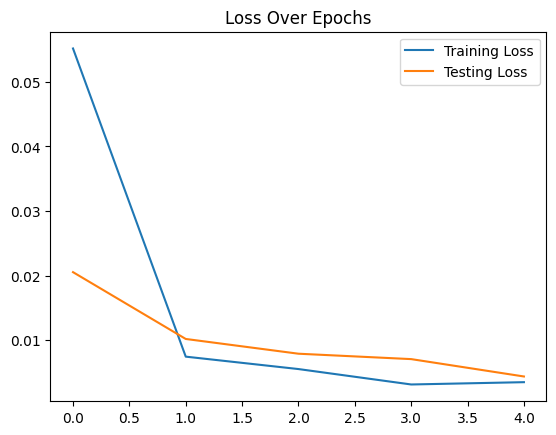

In [17]:
# Plot the training and testing loss progression
plt.plot(train_losses, label = 'Training Loss')
plt.plot(test_losses, label = "Testing Loss")
plt.legend()
plt.title('Loss Over Epochs')
plt.show()



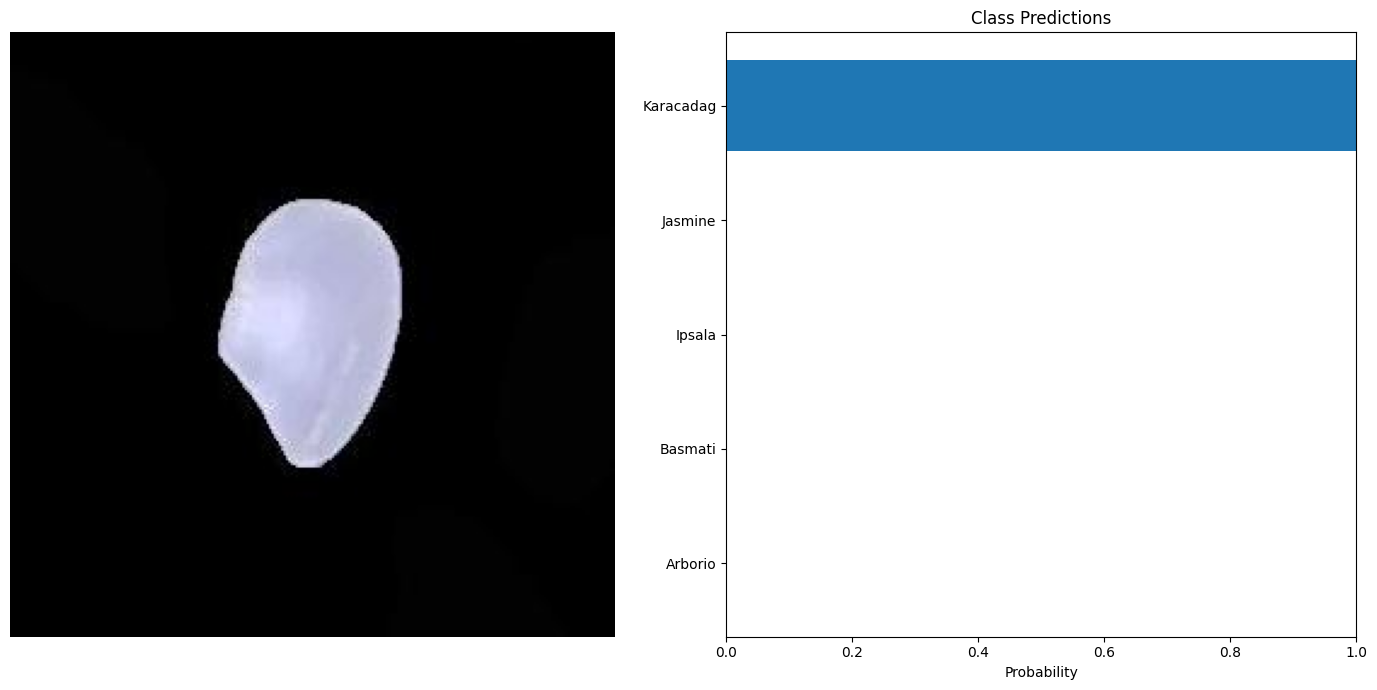

In [20]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def preprocess_image(image_path, transform):
    # Load and convert image to RGB format
    image = Image.open(image_path).convert("RGB")
    # Apply transforms and add batch dimension (unsqueeze)
    return image, transform(image).unsqueeze(0)

def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        # Convert raw outputs (logits) to probabilities via Softmax
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

def visualize_predictions(original_image, probabilities, class_names):
    # Set up a subplot for image and probability bar chart
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7)) 
    
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Plot horizontal bar chart of class probabilities
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# --- Example Usage ---

test_image = "/kaggle/input/rice-image-dataset-train-test-split/Rice_Image_Dataset/test/Karacadag/Karacadag (7324).jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

class_names = test_dataset.classes 
visualize_predictions(original_image, probabilities, class_names)

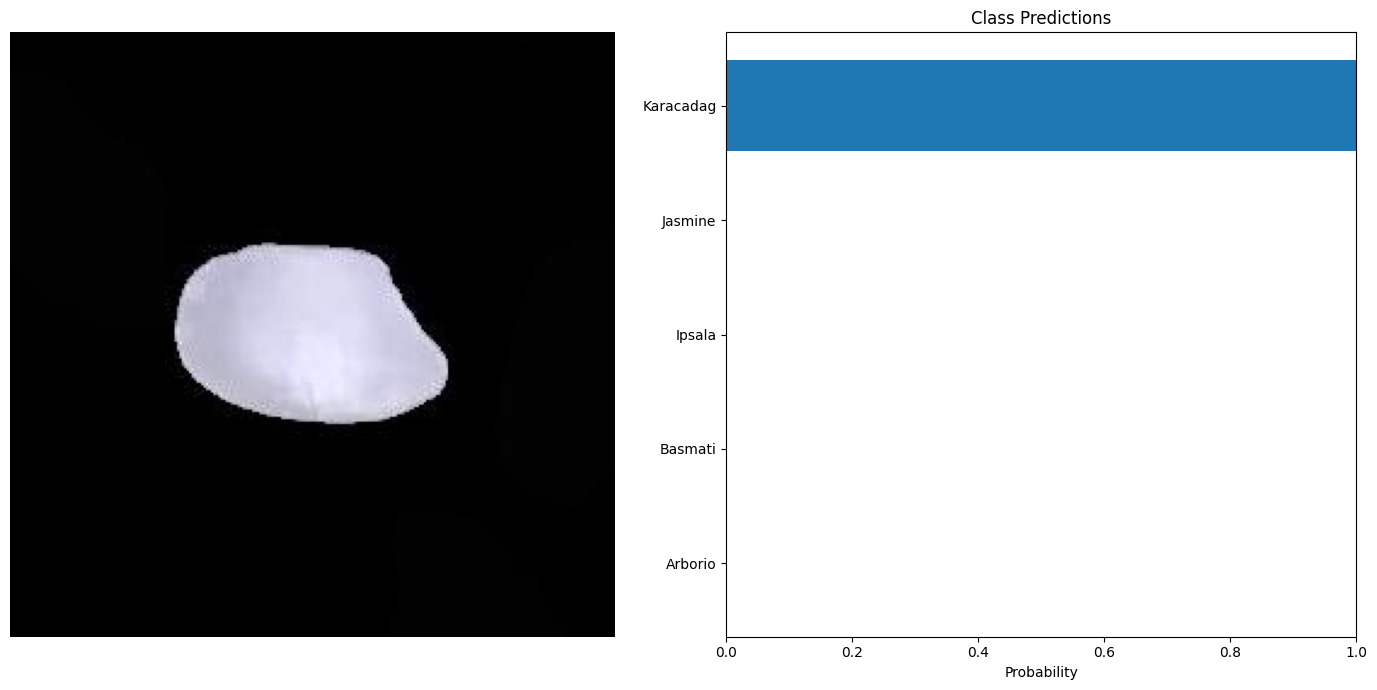

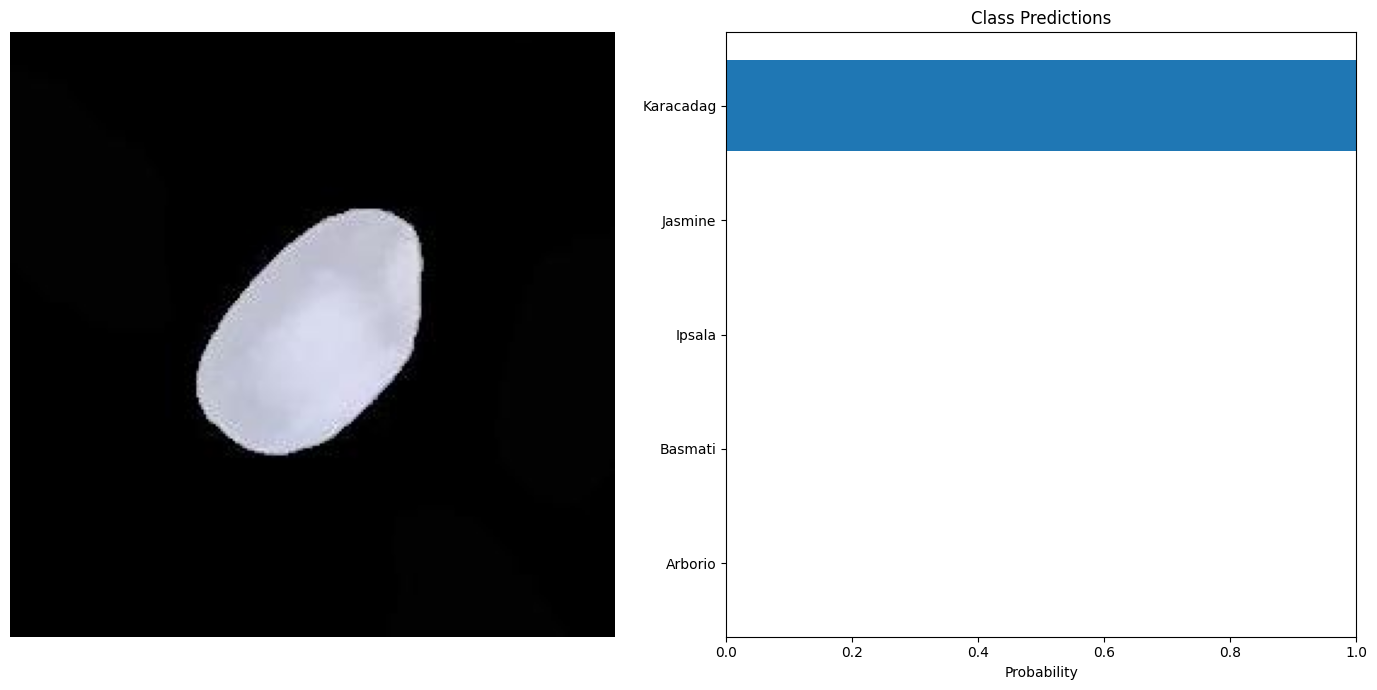

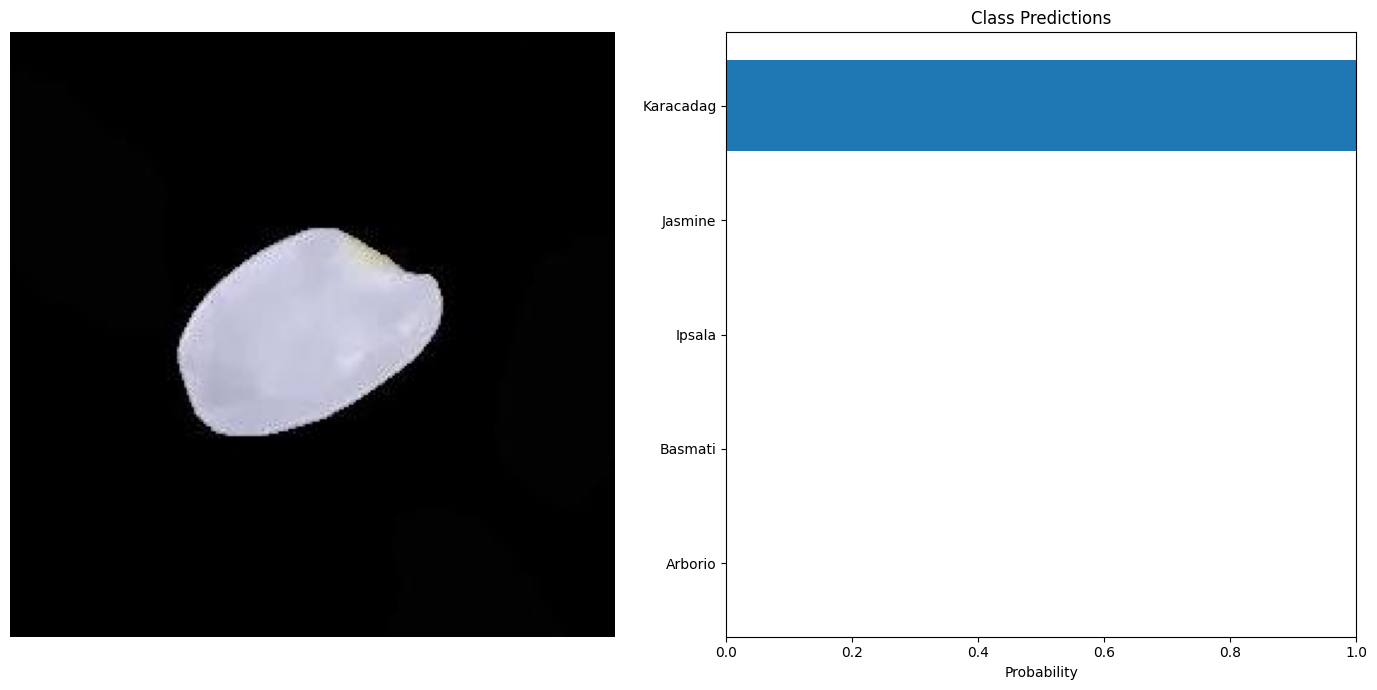

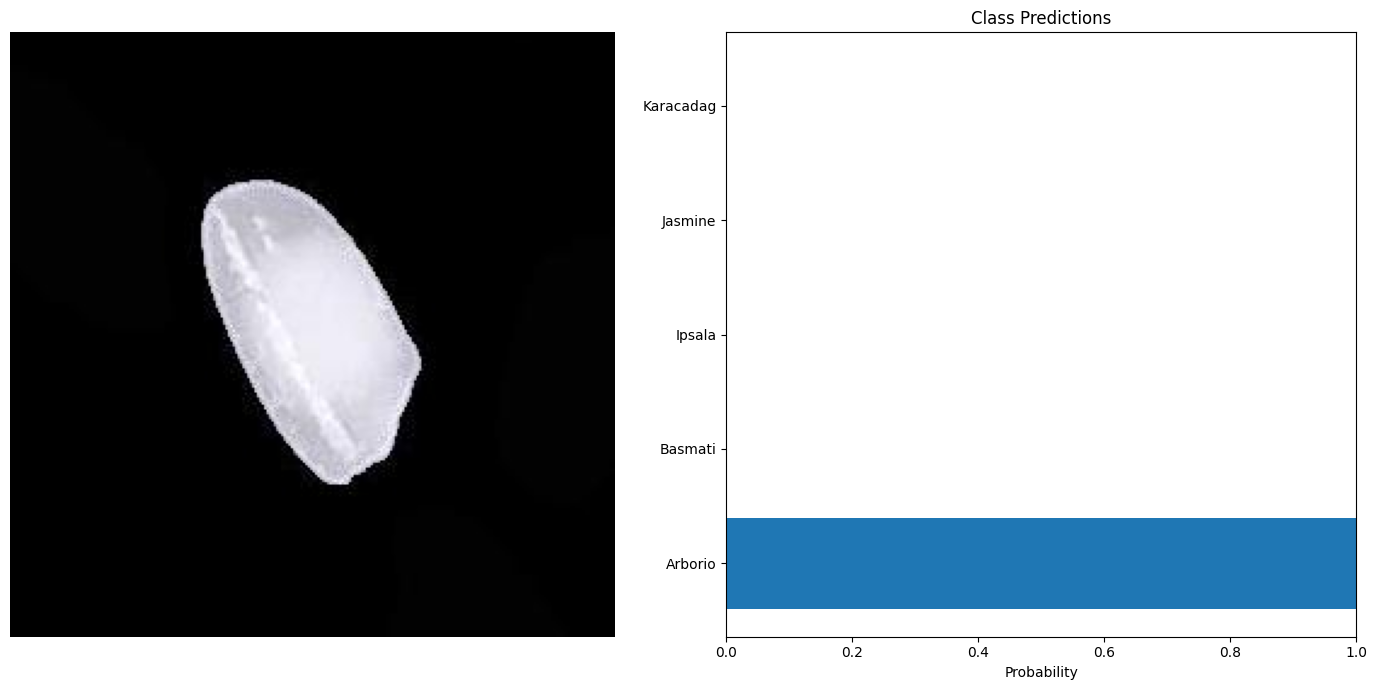

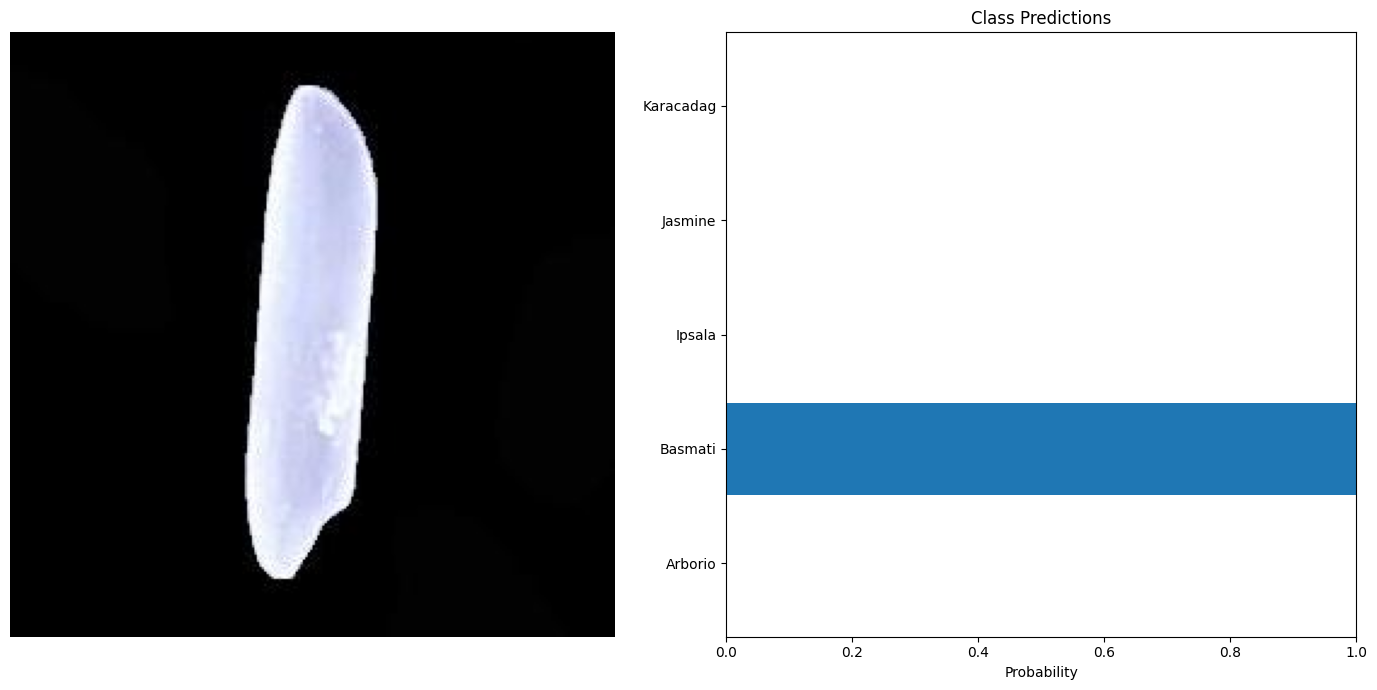

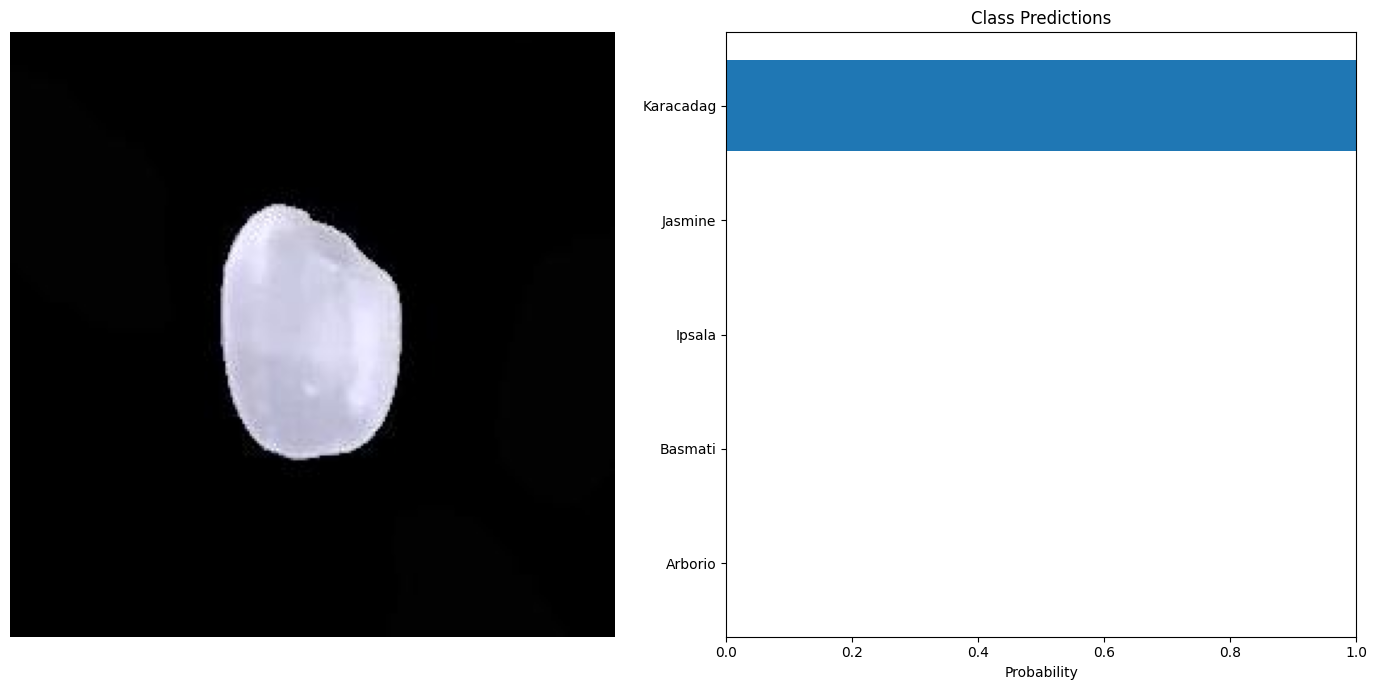

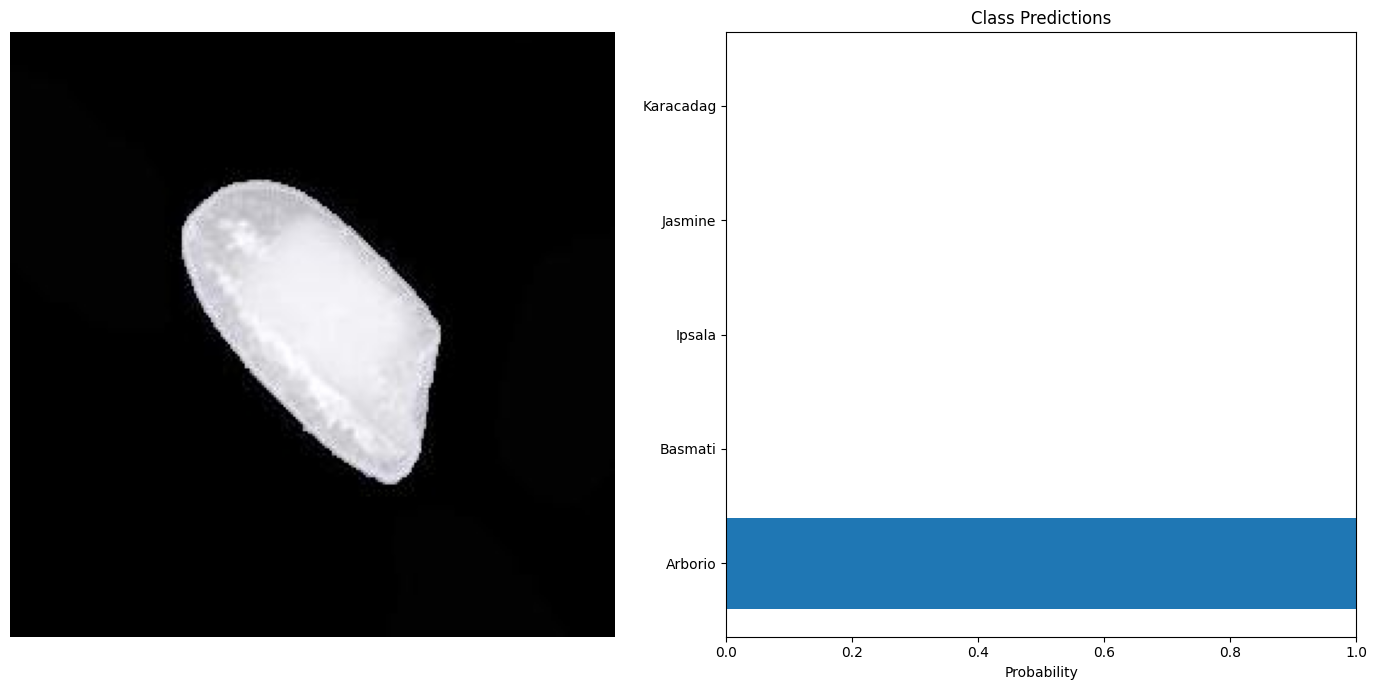

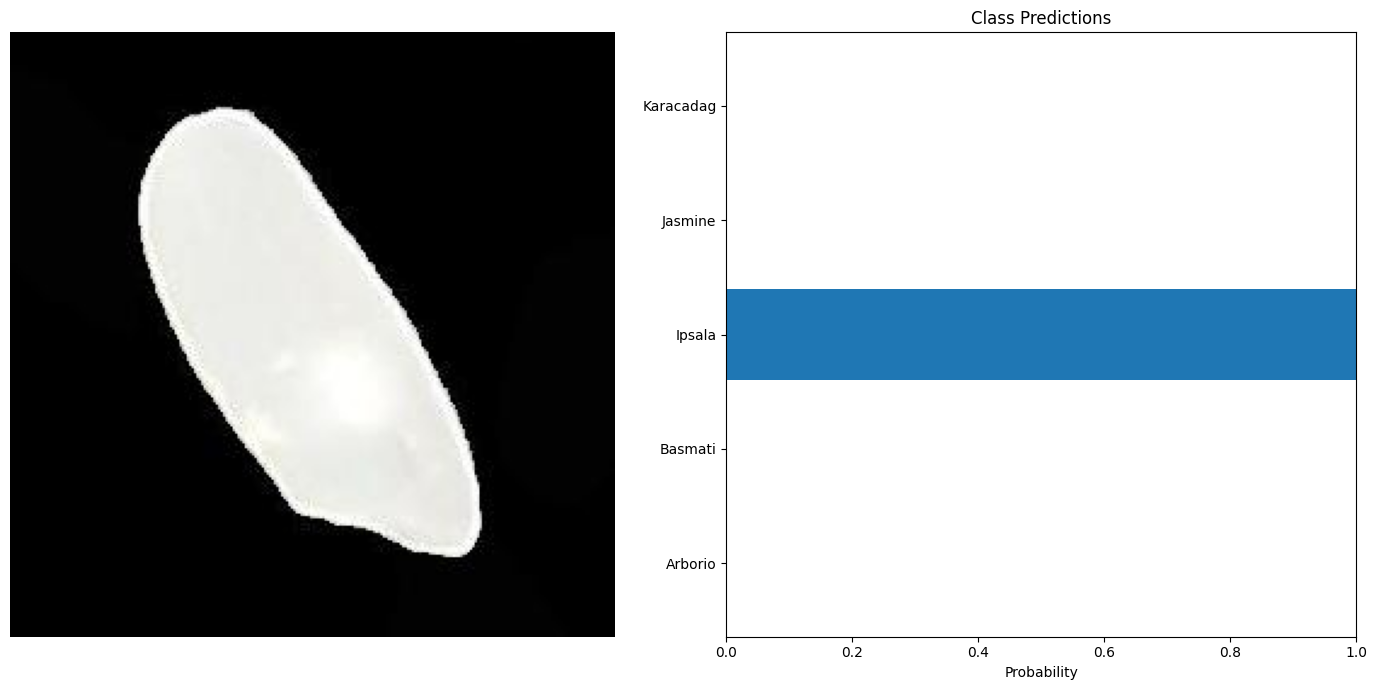

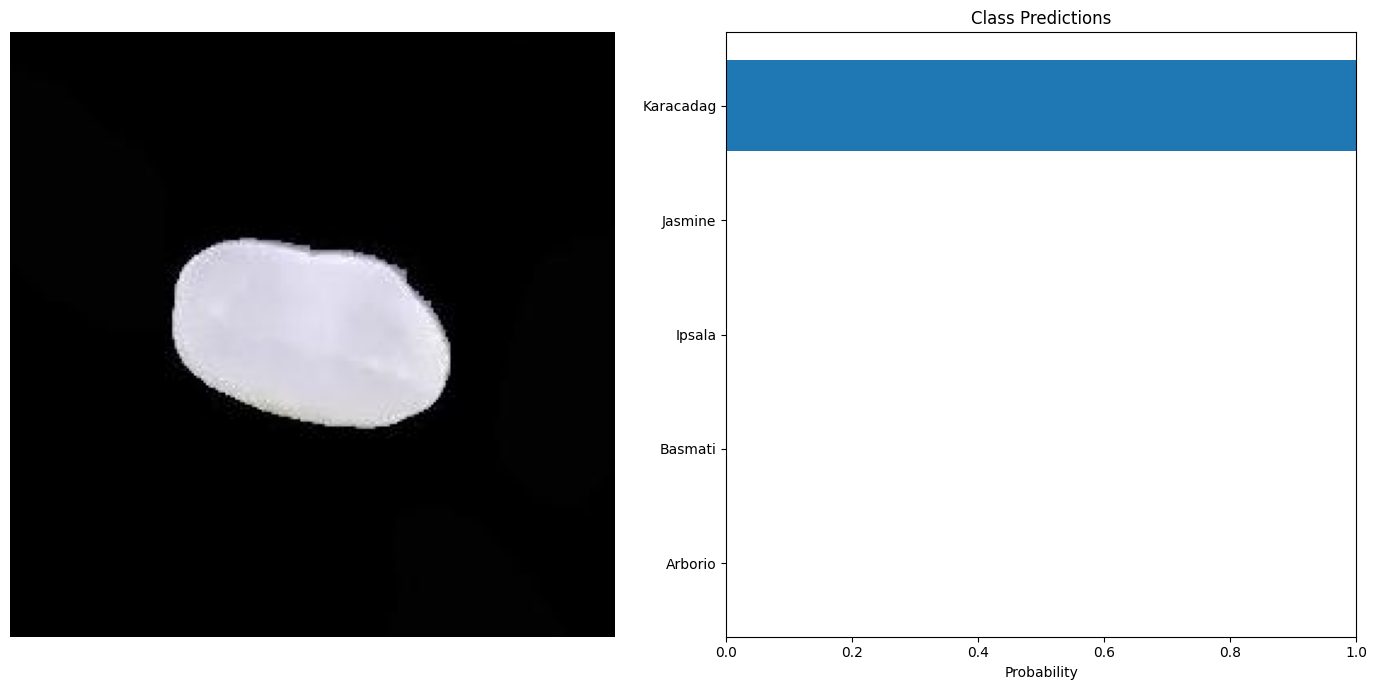

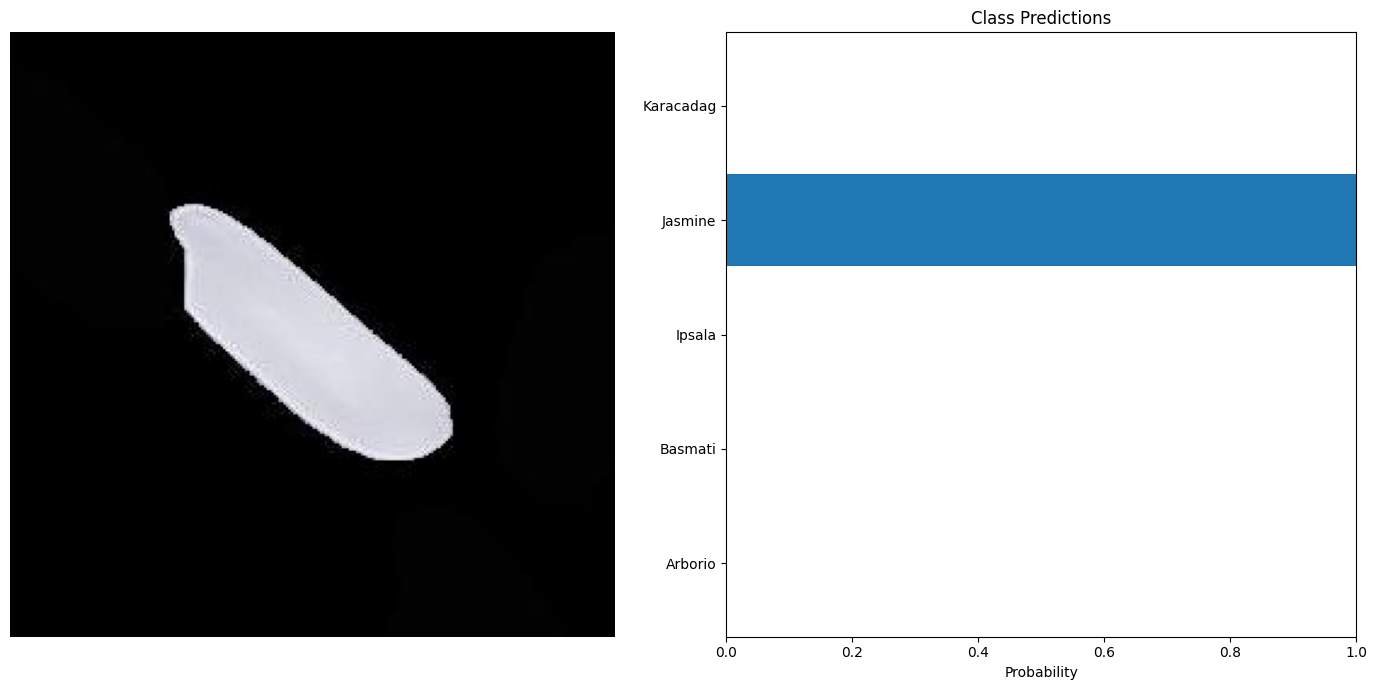

In [24]:
# --- Random Sample Visualization ---
from glob import glob
test_images = glob('../input/rice-image-dataset-train-test-split/Rice_Image_Dataset/test/*/*')
# Select 10 random images for a quick sanity check
test_examples = np.random.choice(test_images, 10) 

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    class_names = test_dataset.classes 
    visualize_predictions(original_image, probabilities, class_names)

In [25]:
# --- Final Accuracy Calculation (Code provided in previous turn) ---
def calculate_accuracy(model, data_loader, device):
    """
    Computes the model's accuracy on the provided data loader.
    """
    # 1. Set the model to evaluation mode (essential for accurate testing)
    model.eval()
    
    correct_predictions = 0
    total_samples = 0
    
    # 2. Disable gradient calculations (saves memory and speeds up testing)
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass to get outputs (logits)
            outputs = model(images)
            
            # Get the predicted class index (highest logit value)
            # torch.max returns (values, indices). We only need the indices [1].
            _, predicted = torch.max(outputs, 1)
            
            # Update counts
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
    
    # Calculate final accuracy as a percentage
    accuracy = (correct_predictions / total_samples) * 100
    return accuracy

# Assuming 'model', 'test_loader', and 'device' are defined from your training script:
test_accuracy = calculate_accuracy(model, test_loader, device)

print(f"Overall Accuracy on the Test Set: {test_accuracy:.2f}%")

Overall Accuracy on the Test Set: 99.91%
